<a href="https://colab.research.google.com/github/byiringiroscar/NLP_FELLOWSHIP/blob/main/OscarAssignments_train_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import os
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
os.chdir("/content/drive/MyDrive/NLP Fellowship/huzalab_doc/week4/")

In [39]:
!pip install torch==1.8.0 torchtext==0.9.0 #compatibility

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import pandas as pd
import re
import torch
from torchtext.legacy import data
from torchtext.legacy.data import Dataset, Example
from torchtext.legacy.data import BucketIterator
import torch.nn as nn
import torch.nn.functional as F

In [41]:
full_dataset = pd.read_csv('50k_imdb_movie_reviews.csv')
full_dataset.head()

,review,sentiment,set
0,I went and saw this movie last night after bei...,1,test
1,Actor turned director Bill Paxton follows up h...,1,test
2,As a recreational golfer with some knowledge o...,1,test
3,"I saw this film in a sneak preview, and it is ...",1,test
4,Bill Paxton has taken the true story of the 19...,1,test


In [42]:
full_dataset['review'].describe()

count                                                 50000
unique                                                49582
top       Loved today's show!!! It was a variety and not...
freq                                                      5
Name: review, dtype: object

In [43]:
full_dataset = full_dataset.drop_duplicates(subset=['review'])
train_dataset = full_dataset[(full_dataset['set'] == 'train')][['review','sentiment']]
test_dataset = full_dataset[(full_dataset['set'] == 'test')][['review','sentiment']]

In [44]:
def preprocessing(texts):
  cleaned_text = []
  for text in texts:
    text = text.lower()
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    html_pattern = re.compile('<.*?>')
    text = emoji_pattern.sub(r'', text)
    text = url_pattern.sub(r'', text)
    text = html_pattern.sub(r'', text)
    text = re.sub(r"[^\w\d'\s]+", ' ', text)
    cleaned_text.append(text)

  return cleaned_text

In [45]:
# get most common words in training dataset
from collections import Counter 
all_words = []
for line in list(full_dataset['review']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
a=Counter(all_words).most_common(10)
a

[('the', 633981),
 ('a', 314408),
 ('and', 311378),
 ('of', 284608),
 ('to', 262599),
 ('is', 203488),
 ('in', 178487),
 ('i', 140393),
 ('this', 137398),
 ('that', 129179)]

In [46]:
#tokenization
full_dataset['review'] = full_dataset['review'].apply(lambda x: x.split())
full_dataset.head()

,review,sentiment,set
0,"[I, went, and, saw, this, movie, last, night, ...",1,test
1,"[Actor, turned, director, Bill, Paxton, follow...",1,test
2,"[As, a, recreational, golfer, with, some, know...",1,test
3,"[I, saw, this, film, in, a, sneak, preview,, a...",1,test
4,"[Bill, Paxton, has, taken, the, true, story, o...",1,test


In [47]:
#stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

full_dataset['review']= full_dataset['review'].apply(lambda x: [stemmer.stem(i) for i in x])
full_dataset.head()

,review,sentiment,set
0,"[i, went, and, saw, this, movi, last, night, a...",1,test
1,"[actor, turn, director, bill, paxton, follow, ...",1,test
2,"[as, a, recreat, golfer, with, some, knowledg,...",1,test
3,"[i, saw, this, film, in, a, sneak, preview,, a...",1,test
4,"[bill, paxton, has, taken, the, true, stori, o...",1,test


In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

#stopwords = set(stopwords.words('english'))
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['u','go','got','via','or','ur','us','in','i','let','the','to','is','amp','make','one','day','days','get']
stopwords.extend(newStopWords)

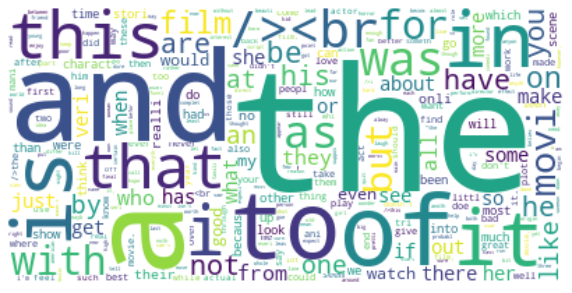

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# split sentences to get individual words
words = []
for line in full_dataset['review']: 
    words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
   ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
def string (text):
    to_return=""
    for i in list(text):
        to_return += str(i) + " "
    to_return = to_return[:-1]
    
    return to_return
    
       
full_dataset['review'] = full_dataset['review'].apply(string)
full_dataset.head() 

,review,sentiment,set
0,i went and saw this movi last night after be c...,1,test
1,actor turn director bill paxton follow up his ...,1,test
2,as a recreat golfer with some knowledg of the ...,1,test
3,"i saw this film in a sneak preview, and it is ...",1,test
4,bill paxton has taken the true stori of the 19...,1,test


In [52]:
del full_dataset['set']

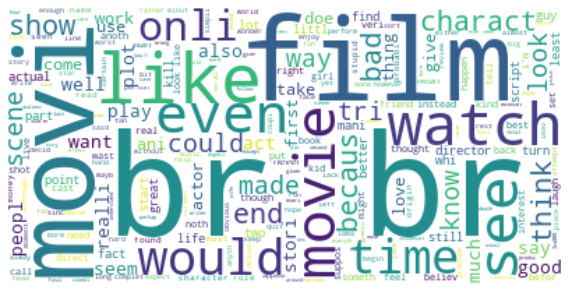

In [53]:
positive = [r for r in full_dataset['review'][full_dataset['sentiment']==0]]
pos = ''.join(positive)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
   ).generate(pos)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
negative = [r for r in full_dataset['review'][full_dataset['sentiment']==0]]
neg = ''.join(negative)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='black',
    max_words=2000,
    stopwords=stopwords
   ).generate(neg)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Split data into training and testing sets 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(full_dataset['review'],full_dataset['sentiment'], test_size = 0.2, random_state = 42)

print("training set :",x_train.shape,y_train.shape)
print("testing set :",x_test.shape,y_test.shape)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

print(x_test_counts.shape)
print(x_test_tfidf.shape)
print(x_train_counts.shape)
print(x_train_tfidf.shape)

#Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300)
model.fit(x_train_tfidf,y_train)
predictions = model.predict(x_test_tfidf)

In [58]:
#Accuracy_score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)*100

85.68115357466975

In [59]:
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(y_test,predictions)

array([[4228,  675],
       [ 745, 4269]])

# Logistc Regression

In [60]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(random_state=400 )
logmodel.fit(x_train_tfidf,y_train)
Log_predictions = logmodel.predict(x_test_tfidf)

In [61]:
#Accuracy_score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,Log_predictions)*100

89.32136734899667

In [62]:
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(y_test,Log_predictions)

array([[4333,  570],
       [ 489, 4525]])

# Gradient Boosting Regressor

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

alg= GradientBoostingRegressor(n_estimators= 550, learning_rate= 0.1, max_depth= 3)
alg.fit(x_train_tfidf,y_train)
alg_predictions = logmodel.predict(x_test_tfidf)

In [64]:
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(y_test,alg_predictions)

array([[4333,  570],
       [ 489, 4525]])

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,alg_predictions)*100

89.32136734899667

# 2. Code for NN model that gives the highest accuracy

In [66]:
SEED = 20

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True # Check this
max_document_length = 300 #hyperparameter

TEXT = data.Field(lower=True, include_lengths=True,  tokenize='spacy',preprocessing=preprocessing,batch_first=True,  fix_length=max_document_length)
LABEL = data.Field(sequential=False, use_vocab=False)

class DataFrameDataset(Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [ ]:
torch_valid_dataset, torch_test_dataset = DataFrameDataset(
    df=test_dataset, 
    fields=(
        ('review', TEXT),
        ('sentiment', LABEL)
    )
).split() 

torch_train_dataset = DataFrameDataset(
    df=train_dataset, 
    fields=(
        ('review', TEXT),
        ('sentiment', LABEL)
    )
)

In [ ]:
max_size = 30000 #hyperparameter
TEXT.build_vocab(torch_train_dataset, max_size=max_size,vectors='fasttext.simple.300d')
vocab_size = len(TEXT.vocab)

BATCH_SIZE = 30 #hyperparameter
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (torch_train_dataset, torch_valid_dataset, torch_test_dataset), 
    batch_size = BATCH_SIZE ,
    sort_key=lambda x: len(x.review),
    sort_within_batch=True)

class MLP(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size2, hidden_size3, hidden_size4, output_dim, dropout, max_document_length):
        super().__init__()
        # embedding and convolution layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(embed_size*max_document_length, hidden_size2)  # dense layer
        self.fc2 = nn.Linear(hidden_size2, hidden_size3)  # dense layer
        self.fc3 = nn.Linear(hidden_size3, hidden_size4)  # dense layer
        self.fc4 = nn.Linear(hidden_size4, output_dim)  # dense layer

    def forward(self, text):
         # text shape = (batch_size, num_sequences)
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
        
        x = embedded.view(embedded.shape[0], -1)  # x = Flatten()(x)
        #embedded = embedded.unsqueeze(1) # fc gets 4 dimension
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        preds = self.fc4(x)
        # preds = F.softmax(preds, 1)
        return preds

In [ ]:
lr = 1e-3
batch_size = 30
dropout_keep_prob = 0.3
embedding_size = 300
max_document_length = 300 # each sentence has until 100 words
vocab_size = len(TEXT.vocab)
dev_size = 0.8 # split percentage to train\validation data
max_size = 30000 # maximum vocabulary size
seed = 35
num_classes = 2

num_epochs = 15
hidden_size = 256
hidden_size1 = 300
hidden_size2 = 128
hidden_size3 = 64

to_train = True

model = MLP(vocab_size, embedding_size, hidden_size1, hidden_size2, hidden_size3,  num_classes, dropout_keep_prob, max_document_length)

In [ ]:
def accuracy(probs, target):
  winners = probs.argmax(dim=1)
  corrects = (winners == target)
  accuracy = corrects.sum().float() / float(target.size(0))
  return accuracy

In [ ]:
best_valid_loss = float('inf')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  train_epoch_loss = 0
  train_epoch_acc = 0
  for batch in train_iterator:
      optimizer.zero_grad()
      # retrieve text and no. of words
      text, text_lengths = batch.review

      #feedforward
      # model.to(device)
      predictions = model(text).squeeze(1)
      
      
      loss = loss_func(predictions, batch.sentiment)

      acc = accuracy(predictions, batch.sentiment)

      # perform backpropagation
      loss.backward()

      optimizer.step()

      train_epoch_loss += loss.item()
      train_epoch_acc += acc.item()

  

  valid_epoch_loss = 0
  valid_epoch_acc = 0

  model.eval()

  with torch.no_grad():
      for batch in valid_iterator:
          text, text_lengths = batch.review

          predictions = model(text).squeeze(1)

          loss = loss_func(predictions, batch.sentiment)

          acc = accuracy(predictions, batch.sentiment)

          valid_epoch_loss += loss.item()
          valid_epoch_acc += acc.item()

   

  if valid_epoch_loss < best_valid_loss:
            best_valid_loss = valid_epoch_loss
            torch.save(model.state_dict(), 'saved_weights'+'_linear.pt')

  print(f'\tTrain Loss: {train_epoch_loss / len(train_iterator):.3f} | Train Acc: {train_epoch_acc  / len(train_iterator)* 100:.2f}%')
  print(f'\t Val. Loss: {valid_epoch_loss / len(valid_iterator):.3f} |  Val. Acc: {valid_epoch_acc / len(valid_iterator) * 100:.2f}%')